# In this notebook, I will present my statistical analysis on the market data for the Two Sigma Competition problem

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()

In [ ]:
import pandas as pd
import numpy as np
import random
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [ ]:
(market_train_df, news_train_df) = env.get_training_data()

# Market data
Our dataset is very interesting. We have a lot of companies here, and data from over a decade.

Personally, I am interested in latest trends than the past ones as these trends will have effect on the future data present in the test. The other trends are captured by the model however. We will keep this in mind when applying feature engineering on the data.

For now, let's look at the date itself. Can we see long-term trends, appearing and declining companies? Let's have a look.

In [ ]:
market_train_df.head()

In [ ]:
def inspect(df):
    """Returns a inspection dataframe"""
    print ("Length of dataframe:", len(df))
    inspect_dataframe = pd.DataFrame({'dtype': df.dtypes, 'Unique values': df.nunique() ,
                 'Number of missing values': df.isna().sum() ,
                  'Percentage missing': (df.isna().sum() / len(df)) * 100
                 }).sort_values(by='Number of missing values', ascending = False)
    return inspect_dataframe


In [ ]:
inspect(market_train_df)

In [ ]:
print(f'{market_train_df.shape[0]} samples and {market_train_df.shape[1]} features in the training market dataset.')

In [ ]:
print ("The oldest date in dataset", market_train_df['time'].min())
print ("The latest date in dataset", market_train_df['time'].max())


## Let's look at the `assetCode` column

In [ ]:
print(f'There are {market_train_df["assetCode"].nunique()} unique assets in the dataset.')

In [ ]:
print(f"There are {market_train_df['time'].isna().sum()} missing values in the `assetCode` column")

Let's have a look at the random market data

In [ ]:
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color

In [ ]:
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 10):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Closing prices of 10 random assets",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

I plot data for all periods because I'd like to show long-term trends. Assets are sampled randomly, but you should see that some companies' stocks started trading later, some dissappeared. Disappearence could be due to bankruptcy, acquisition or other reasons.

Well, these were some random companies. But it would be more interesting to see general trends of prices.

**Top 10 Largest Assets code by Close value**

Please note: we don't have high and low data in the dataset

In [ ]:
best_asset_volume = market_train_df.groupby("assetCode")["close"].count().to_frame().sort_values(by=['close'],ascending= False)
best_asset_volume = best_asset_volume.sort_values(by=['close'])
largest_by_volume = list(best_asset_volume.nlargest(10, ['close']).index)
# largest_by_volume

In [ ]:
for i in largest_by_volume:
    asset1_df = market_train_df[(market_train_df['assetCode'] == i) & (market_train_df['time'] > '2015-01-01') & (market_train_df['time'] < '2017-01-01')]
    # Create a trace
    trace1 = go.Scatter(
        x = asset1_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset1_df['close'].values,
        line = dict(color = generate_color()),opacity = 0.8
    )

    layout = dict(title = "Closing prices of {}".format(i),
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  )

    data = [trace1]
    py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
volumeByAssets = market_train_df.groupby(market_train_df['assetCode'])['volume'].sum()
highestVolumes = volumeByAssets.sort_values(ascending=False)[0:10]

# Create a trace
trace1 = go.Pie(
    labels = highestVolumes.index,
    values = highestVolumes.values
)

layout = dict(title = "Highest trading volumes")
data = [trace1]

py.iplot(dict(data=data, layout=layout), filename='basic-line')

## Assets By Trading Days

In [ ]:
market_train_df['time'].dt.date.describe()

In [ ]:
assetsByTradingDay = market_train_df.groupby(market_train_df['time'].dt.date)['assetCode'].nunique()

In [ ]:
# Create a trace
trace1 = go.Bar(
    x = assetsByTradingDay.index, # asset1_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = assetsByTradingDay.values
)

layout = dict(title = "# of assets by trading days",
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = '# of assets'),
              )
data = [trace1]

py.iplot(dict(data=data, layout=layout), filename='basic-line')

## Unknown Value By Assets Code

*the name that corresponds to a group of assetCodes. These may be "Unknown" if the corresponding assetCode does not have any rows in the news data.*

In [ ]:
print("There are {:,} records with assetName = `Unknown` in the dataset".format(market_train_df[market_train_df['assetName'] == 'Unknown'].size))

In [ ]:
assetNameGB = market_train_df[market_train_df['assetName'] == 'Unknown'].groupby('assetCode')
unknownAssets = assetNameGB.size().reset_index('assetCode')
unknownAssets.columns = ['assetCode',"value"]
unknownAssets = unknownAssets.sort_values("value", ascending= False)
unknownAssets.head(5)

colors = []
for i in range(len(unknownAssets)):
     colors.append(generate_color())

        
data = [
    go.Bar(
        x = unknownAssets.assetCode.head(25),
        y = unknownAssets.value.head(25),
        name = 'Unknown Assets',
        textfont=dict(size=20),
        marker=dict(
        color= colors,
        line=dict(
            color='#000000',
            width=2,
        ), opacity = 0.45
    )
    ),
    ]
layout= go.Layout(
    title= 'Unknown Assets by Asset code',
    xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
    yaxis=dict(title='Value Count', ticklen=5, gridwidth=2),
    showlegend=True
)
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='skin')

Now, let's look at these price drops in details.

In [ ]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()

In [ ]:
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * g['price_diff']['min']).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
#     text = f"Maximum price drop: {g['price_diff']['min'].values}"
#     g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

We can see huge price fluctiations when market crashed. Just think about it... But this is wrong! There was no huge crash on January 2010... Let's dive into the data!

**Possible data errors**

At first let's simply sort data by the difference between open and close prices.

In [ ]:
market_train_df.sort_values('price_diff')[:10]

I think for our first 5 rows in our data is simply an error

But what about Bank of New York Mellon Corp?

Let's see data by Yahoo:

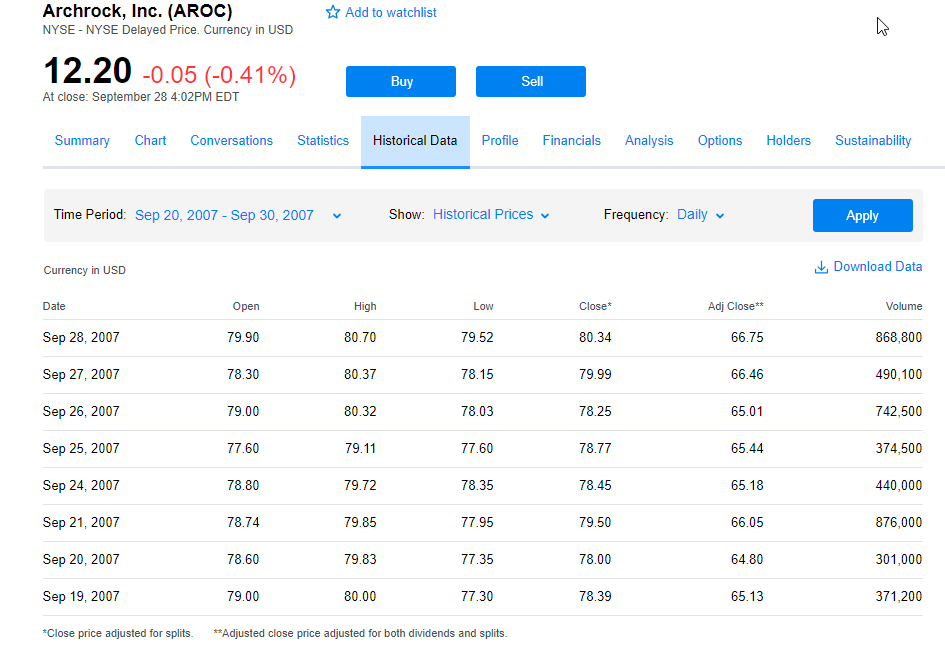
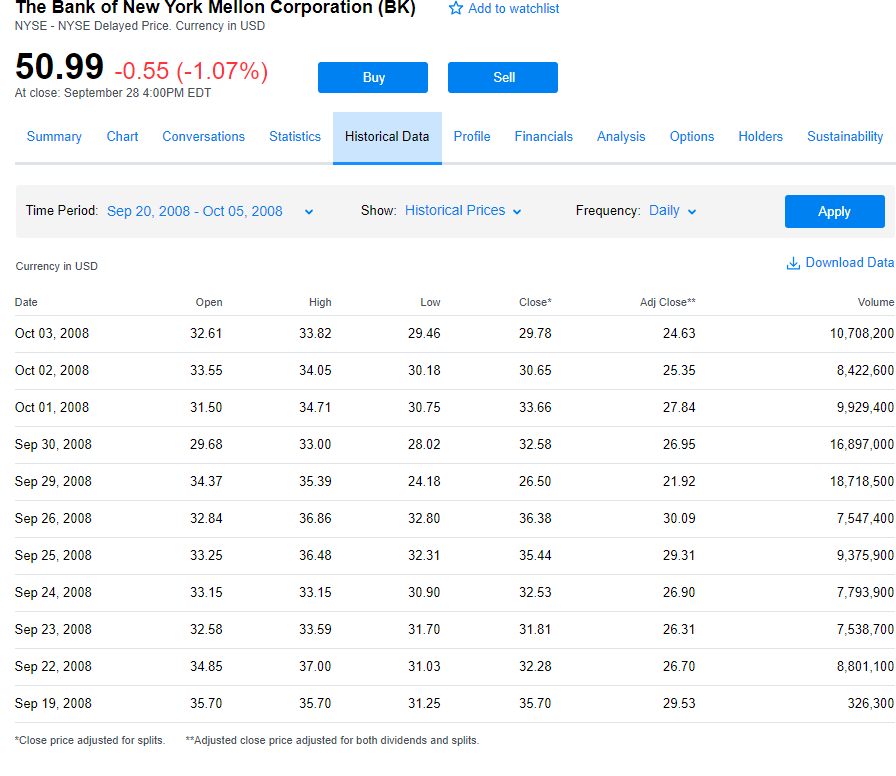

Unfortunately, historical data on Towers Watson & Co is not available on yahoo, but looking at those screenshot it must be an error.

In [ ]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])

In [ ]:
print(f"In {(market_train_df['close_to_open'] >= 1.2).sum()} lines price increased by 20% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.8).sum()} lines price decreased by 20% or more.")

Well, this isn't much considering we have more than 4 million lines and a lot of these cases are due to price falls during market crash. Well just need to deal with outliers.

In [ ]:
data = []
market_train_df['month'] = market_train_df['time'].dt.month
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('month')['returnsOpenNextMktres10'].quantile(i).reset_index()
    data.append(go.Bar(
        x = price_df['month'].values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of grouby Month of returnsOpenNextMktres10 by 10 quartiles ",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="v"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
print(f"In {(market_train_df['close_to_open'] >= 2).sum()} lines price increased by 100% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.5).sum()} lines price decreased by 100% or more.")

For a quick fix I'll replace outliers in these lines with mean open or close price of this company.

In [ ]:
market_train_df['assetName_mean_open'] = market_train_df.groupby('assetName')['open'].transform('mean')
market_train_df['assetName_mean_close'] = market_train_df.groupby('assetName')['close'].transform('mean')

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in market_train_df.loc[market_train_df['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_train_df.loc[market_train_df['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']

Now let's try to build that graph again.

In [ ]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values * 5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


Now the graph is much more reasonable.

Now let's take a look at out target variable.



In [ ]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')


We can see that quantiles have a high deviation, but mean value doesn't change much.

Now I think it is time to throw an old part of dataset. Let's leave only data since 2010 year, this way we will get rid of the data of the biggest crisis.

Let's look at the target variable now.

In [ ]:
data = []
market_train_df = market_train_df.loc[market_train_df['time'] >= '2010-01-01 22:00:00+0000']

price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].mean().reset_index()

data.append(go.Scatter(
    x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = price_df['returnsOpenNextMktres10'].values,
    name = f'{i} quantile'
))
layout = go.Layout(dict(title = "Treand of returnsOpenNextMktres10 mean",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Fluctuations seem to be high, but in fact they are lower that 8 percent. In fact it looks like a random noise...

Let's have a look at means of these variables.

In [ ]:
data = []
for col in ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10']:
    df = market_train_df.groupby('time')[col].mean().reset_index()
    data.append(go.Scatter(
        x = df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df[col].values,
        name = col
    ))
    
layout = go.Layout(dict(title = "Treand of mean values",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Well, for me it is difficult to interpret this, but it seems that returns for previous 10 days fluctuate the most.